# Análisis exploratorio del Ultra Marathon Transvulcania

Situada en la bucólica y agreste isla de La Palma, conocida como la isla bonita de las Canarias, la Transvulcania tiene una personalidad muy marcada, con 73 kilómetros de recorrido entre volcanes, bosques y playas de arena negra. Originariamente, este sendero fue la principal ruta de trashumancia de ganadería de La Palma y servía para comunicar las localidades más alejadas entre si.

### Librerías para el EDA

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import pearsonr
import re

### Exploración inicial del dataset completo

El dataset incluye un total de 7.461.226 registros de carreras de ultramaratón con 1.641.168 atletas únicos, registrados en carreras de todo el mundo entre 1798 y 2022. Puede consultarse y descargarse [aquí](https://www.kaggle.com/datasets/aiaiaidavid/the-big-dataset-of-ultra-marathon-running?select=TWO_CENTURIES_OF_UM_RACES.csv).

In [2]:
# Cargar el conjunto de datos

df = pd.read_csv(
    "ultra-marathon-dataset/TWO_CENTURIES_OF_UM_RACES.csv",
    dtype={"age_category": str},
    low_memory=False  # Prevenir advertencias de tipo de datos
)
df.head(5)

,Year of event,Event dates,Event name,Event distance/length,Event number of finishers,Athlete performance,Athlete club,Athlete country,Athlete year of birth,Athlete gender,Athlete age category,Athlete average speed,Athlete ID
0,2018,06.01.2018,Selva Costera (CHI),50km,22,4:51:39 h,Tnfrc,CHI,1978.0,M,M35,10.286,0
1,2018,06.01.2018,Selva Costera (CHI),50km,22,5:15:45 h,Roberto Echeverría,CHI,1981.0,M,M35,9.501,1
2,2018,06.01.2018,Selva Costera (CHI),50km,22,5:16:44 h,Puro Trail Osorno,CHI,1987.0,M,M23,9.472,2
3,2018,06.01.2018,Selva Costera (CHI),50km,22,5:34:13 h,Columbia,ARG,1976.0,M,M40,8.976,3
4,2018,06.01.2018,Selva Costera (CHI),50km,22,5:54:14 h,Baguales Trail,CHI,1992.0,M,M23,8.469,4


In [3]:
# Verificar la forma del DataFrame

df.shape

(7461195, 13)

### Exploración inicial y limpieza de los datos de Transvulcania

Se realiza una pequeña exploración de los datos para determinar si existen nulos y, en caso afirmativo, tomar una decisión sobre cómo tratarlos. 

In [4]:
# Filtrar el DataFrame para incluir solo las filas donde "event_name" contiene "Transvulcania" y contar la cantidad de registros

df_transvulcania = df[df["Event name"].str.contains("Transvulcania", na=False, case=False)]

print(f"Cantidad de registros para Transvulcania: {len(df_transvulcania)}")

Cantidad de registros para Transvulcania: 10493


In [5]:
# Verificar si hay duplicados en el DataFrame 

df_transvulcania[df_transvulcania.duplicated() == True]

,Year of event,Event dates,Event name,Event distance/length,Event number of finishers,Athlete performance,Athlete club,Athlete country,Athlete year of birth,Athlete gender,Athlete age category,Athlete average speed,Athlete ID


In [6]:
# Visualizar los datos del comienzo y del final del DataFrame

pd.concat([df_transvulcania.head(2), df_transvulcania.tail(2)])

,Year of event,Event dates,Event name,Event distance/length,Event number of finishers,Athlete performance,Athlete club,Athlete country,Athlete year of birth,Athlete gender,Athlete age category,Athlete average speed,Athlete ID
303564,2018,12.05.2018,Transvulcania 2018 (ESP),73km,1368,7:37:26 h,Chemotuga,ESP,1983.0,M,M23,9.575,129630
303565,2018,12.05.2018,Transvulcania 2018 (ESP),73km,1368,7:38:22 h,Adidas Terrex,RUS,1991.0,M,M23,9.556,60760
6503915,2015,09.-10.05.2015,Transvulcania 2015 (ESP),73km,1090,16:52:50 h,NaN,ESP,NaN,M,NaN,4.325,1435776
6503916,2015,09.-10.05.2015,Transvulcania 2015 (ESP),73km,1090,16:58:22 h,NaN,POL,1959.0,M,M55,4.301,229770


In [7]:
# Renombrar las columnas del DataFrame para que sean más legibles y consistentes

df_transvulcania = df_transvulcania.rename(columns={
    "Year of event": "year",
    "Event dates": "event_date",
    "Event name": "event_name",
    "Event distance/length": "distance_km",
    "Event number of finishers": "num_finishers",
    "Athlete performance": "performance",
    "Athlete club": "club",
    "Athlete country": "country",
    "Athlete year of birth": "birth_year",
    "Athlete gender": "gender",
    "Athlete age category": "age_category",
    "Athlete average speed": "avg_speed",
    "Athlete ID": "athlete_id"
})

In [8]:
# Verificar los tipos de datos

df_transvulcania.dtypes

year               int64
event_date        object
event_name        object
distance_km       object
num_finishers      int64
performance       object
club              object
country           object
birth_year       float64
gender            object
age_category      object
avg_speed         object
athlete_id         int64
dtype: object

### Limpieza de datos y conversión de tipos

In [9]:
import re

def clean_event_date(date_str):
    if pd.isna(date_str):
        return np.nan
    match = re.search(r'(\d{2}\.\d{2}\.\d{4})$', date_str)
    if match:
        return match.group(1)
    return date_str

df_transvulcania["event_date"] = df_transvulcania["event_date"].apply(clean_event_date)
df_transvulcania["event_date"] = pd.to_datetime(df_transvulcania["event_date"], format="%d.%m.%Y", errors="coerce")

In [10]:
df_transvulcania["distance_km"] = df_transvulcania["distance_km"].str.extract(r'(\d+\.?\d*)')[0].astype(float)

In [11]:
def convert_performance(time_str):
    if pd.isna(time_str):
        return pd.NaT
    try:
        return pd.to_timedelta(time_str.replace(" h", ""))
    except:
        return pd.NaT

df_transvulcania["performance"] = df_transvulcania["performance"].apply(convert_performance)

In [12]:
df_transvulcania["birth_year"] = df_transvulcania["birth_year"].astype("Int64")

In [13]:
df_transvulcania["avg_speed"] = pd.to_numeric(df_transvulcania["avg_speed"], errors="coerce")

In [14]:
# Verificar de nuevo los tipos de datos
df_transvulcania.dtypes

year                       int64
event_date        datetime64[ns]
event_name                object
distance_km              float64
num_finishers              int64
performance      timedelta64[ns]
club                      object
country                   object
birth_year                 Int64
gender                    object
age_category              object
avg_speed                float64
athlete_id                 int64
dtype: object

In [15]:
# Cantidad de valores nulos por columna

print("\nValores nulos por columna:")
print(df_transvulcania.isnull().sum())


Valores nulos por columna:
year                0
event_date          0
event_name          0
distance_km         0
num_finishers       0
performance         0
club             4874
country             0
birth_year       1843
gender              0
age_category     1835
avg_speed           0
athlete_id          0
dtype: int64


A la hora de tratar el dato del club, se asumirá que los nulos son no afiliados. Para unificar con otros posibles no afiliados, primero se realizará una búsqueda con términos comunes para indicar la ausencia de club.

In [16]:
# Lista de términos comunes que indican que no están afiliados
non_affiliated_terms = [
    "unaffiliated", "no club", "self-supported", "independent", "none", "no affiliation", "no team", "N/A", "independiente", "unattached", "no association", "without club", "non-affiliated", "free agent", "non-club", "non-registered", "sin equipo", "no afiliado", "no club", "sin agrupación", "libre", "sin equipo", "autónomo", "ninguno"
]

# Filtrar los clubs para encontrar coincidencias con esos términos
non_affiliated_clubs = df_transvulcania[df_transvulcania["club"].str.contains('|'.join(non_affiliated_terms), case=False, na=False)]
print("Posibles no afiliados:")
print(non_affiliated_clubs["club"].unique())

# Excluir coincidencias no deseadas como "Canarias Libre" y añadir "GOT Medano Team" en un solo paso
non_affiliated_clubs = non_affiliated_clubs[~non_affiliated_clubs["club"].str.contains("canarias libre", case=False, na=False)]
non_affiliated_clubs = non_affiliated_clubs[~non_affiliated_clubs["club"].str.contains("GOT Medano Team", case=False, na=False)]

# Mostrar los resultados
print("\nNo afiliados excluyendo excepciones:")
print(non_affiliated_clubs["club"].unique())

Posibles no afiliados:
['Independientemente' 'Ninguno' 'NO Team' 'SIN Equipo'
 'NO (Independiente)' 'Libre' 'GOT Medano Team' 'NO (Independente)'
 'Unattached' 'Canarias Libre' 'I Am Still In No Team']

No afiliados excluyendo excepciones:
['Independientemente' 'Ninguno' 'NO Team' 'SIN Equipo'
 'NO (Independiente)' 'Libre' 'NO (Independente)' 'Unattached'
 'I Am Still In No Team']


In [17]:
# Reemplazar todos esos términos por "Unaffiliated"
df_transvulcania.loc[:,"club"] = df_transvulcania["club"].replace(non_affiliated_terms, "Unaffiliated")

In [18]:
# Reemplazar los valores nulos en "club" por "Unaffiliated"
df_transvulcania.loc[:, "club"] = df_transvulcania["club"].fillna("Unaffiliated")

Antes de decidir qué hacer con los valores nulos del año de nacimiento y la categoría por edad, se explora la distribución de edades para averiguar si existen outliers que deberían tenerse en cuenta.

In [19]:
# Estadísticas básicas de "birth_year"
df_transvulcania["birth_year"].describe()

count         8650.0
mean     1976.166705
std         8.113013
min           1943.0
25%           1971.0
50%           1976.0
75%           1982.0
max           2001.0
Name: birth_year, dtype: Float64

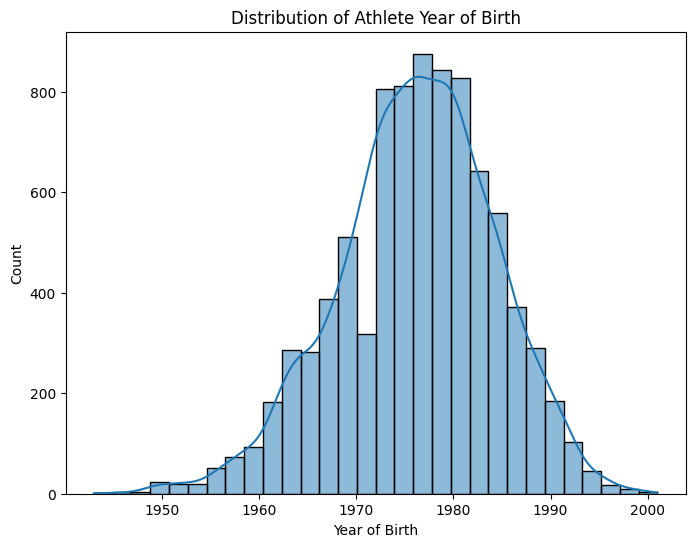

In [20]:
# Histograma de los años de nacimiento de los atletas

plt.figure(figsize=(8, 6))
sns.histplot(df_transvulcania["birth_year"].dropna(), bins=30, kde=True)
plt.xlabel("Year of Birth")
plt.ylabel("Count")
plt.title("Distribution of Athlete Year of Birth")
plt.show()

**Distribución de los datos:**

El histograma muestra una distribución bastante normal con un pico entre 1970 y 1980. Hay pocos valores extremos antes de 1950 y después del 2000.

In [21]:
# Usar una imputación aleatoria dentro del IQR (1971-1982) para rellenar los valores nulos de "birth_year"

np.random.seed(42) 
random_years = np.random.randint(1971, 1983, size=df_transvulcania["birth_year"].isna().sum())
df_transvulcania.loc[df_transvulcania["birth_year"].isna(), "birth_year"] = random_years

In [22]:
df_transvulcania["age"] = df_transvulcania["year"] - df_transvulcania["birth_year"]

In [23]:
age_categories = df_transvulcania["age_category"].unique()
print("Categorías de edad:", age_categories)

Categorías de edad: ['M23' 'M40' 'M35' 'MU23' 'W35' 'W23' nan 'M45' 'M50' 'W40' 'M55' 'W50'
 'W45' 'M65' 'M60' 'W55' 'W60' 'M70' 'WU23']


Parece que las categorías de edad siguen un formato basado en género y rango de edad:

- "M" y "W" indican el género:
    - M → Male (Hombres)
    - W → Women (Mujeres)

- Los números indican grupos de edad:
    - 23, 35, 40, 45, 50, etc. → Probablemente indican la edad mínima de cada categoría.
    - MU23 / WU23 → "Under 23" (Menores de 23 años).

In [24]:
def assign_age_category(row):
    age = row["age"]
    gender = row["gender"]

    if age < 23:
        return f"{gender}U23"
    elif age < 35:
        return f"{gender}23"
    elif age < 40:
        return f"{gender}35"
    elif age < 45:
        return f"{gender}40"
    elif age < 50:
        return f"{gender}45"
    elif age < 55:
        return f"{gender}50"
    elif age < 60:
        return f"{gender}55"
    elif age < 65:
        return f"{gender}60"
    elif age < 70:
        return f"{gender}65"
    else:
        return f"{gender}70"

# Solo aplicamos la función a los valores nulos
df_transvulcania.loc[pd.isnull(df_transvulcania["age_category"]), "age_category"] = \
    df_transvulcania[pd.isnull(df_transvulcania["age_category"])].apply(assign_age_category, axis=1)

In [25]:
# Verificar nuevamente los valores nulos

print("\nValores nulos por columna:")
print(df_transvulcania.isnull().sum())


Valores nulos por columna:
year             0
event_date       0
event_name       0
distance_km      0
num_finishers    0
performance      0
club             0
country          0
birth_year       0
gender           0
age_category     0
avg_speed        0
athlete_id       0
age              0
dtype: int64


In [26]:
pd.concat([df_transvulcania.head(2), df_transvulcania.tail(2)])

,year,event_date,event_name,distance_km,num_finishers,performance,club,country,birth_year,gender,age_category,avg_speed,athlete_id,age
303564,2018,2018-05-12,Transvulcania 2018 (ESP),73.0,1368,0 days 07:37:26,Chemotuga,ESP,1983,M,M23,9.575,129630,35
303565,2018,2018-05-12,Transvulcania 2018 (ESP),73.0,1368,0 days 07:38:22,Adidas Terrex,RUS,1991,M,M23,9.556,60760,27
6503915,2015,2015-05-10,Transvulcania 2015 (ESP),73.0,1090,0 days 16:52:50,Unaffiliated,ESP,1975,M,M40,4.325,1435776,40
6503916,2015,2015-05-10,Transvulcania 2015 (ESP),73.0,1090,0 days 16:58:22,Unaffiliated,POL,1959,M,M55,4.301,229770,56


In [27]:
# Años disponibles en los datos

available_years = sorted(df_transvulcania["year"].unique().tolist())
print("Available years in order:", available_years)

Available years in order: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [28]:
# Distribución de género

print("\nCantidad de hombres y mujeres:")
print(df_transvulcania["gender"].value_counts())


Cantidad de hombres y mujeres:
gender
M    9470
F    1023
Name: count, dtype: int64


### Visualización de los datos

#### 1. Número de finishers a lo largo de los años

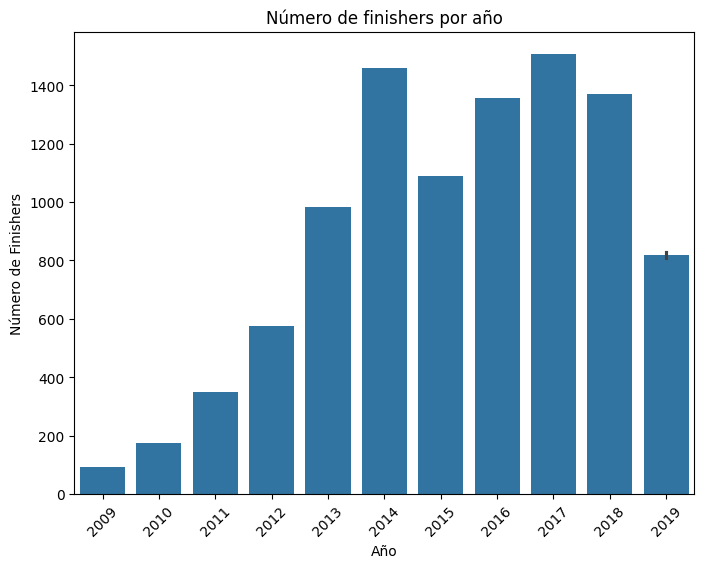

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='year', y='num_finishers', data=df_transvulcania)

plt.title("Número de finishers por año")
plt.xlabel("Año")
plt.ylabel("Número de Finishers")
plt.xticks(rotation=45) 
plt.show()

#### 2. Performance media a lo largo de los años

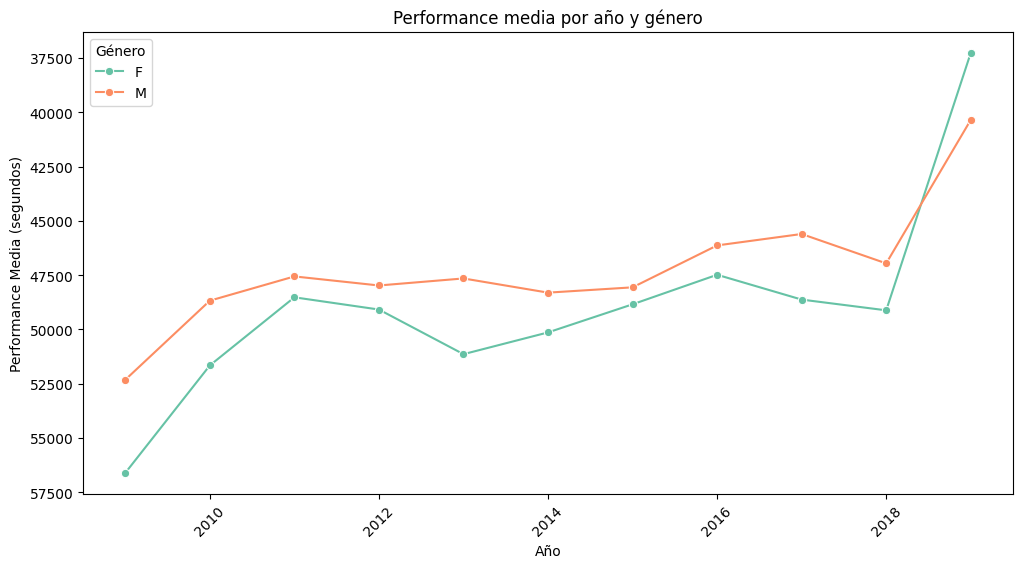

In [ ]:
df_transvulcania['performance'] = df_transvulcania['performance'].dt.total_seconds()  # Convertir a segundos

# Agrupar por 'year' y 'gender' y obtener la performance media
performance_by_year_gender = df_transvulcania.groupby(['year', 'gender'])['performance'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='performance', hue='gender', data=performance_by_year_gender, marker='o', palette="Set2")
plt.gca().invert_yaxis() # Invertir el eje Y para que los tiempos más bajos estén arriba
plt.title("Performance media por año y género")
plt.xlabel("Año")
plt.ylabel("Performance Media (segundos)")
plt.xticks(rotation=45)
plt.legend(title="Género", loc="upper left")
plt.show()

#### 3. Participación de mujeres a lo largo de los años

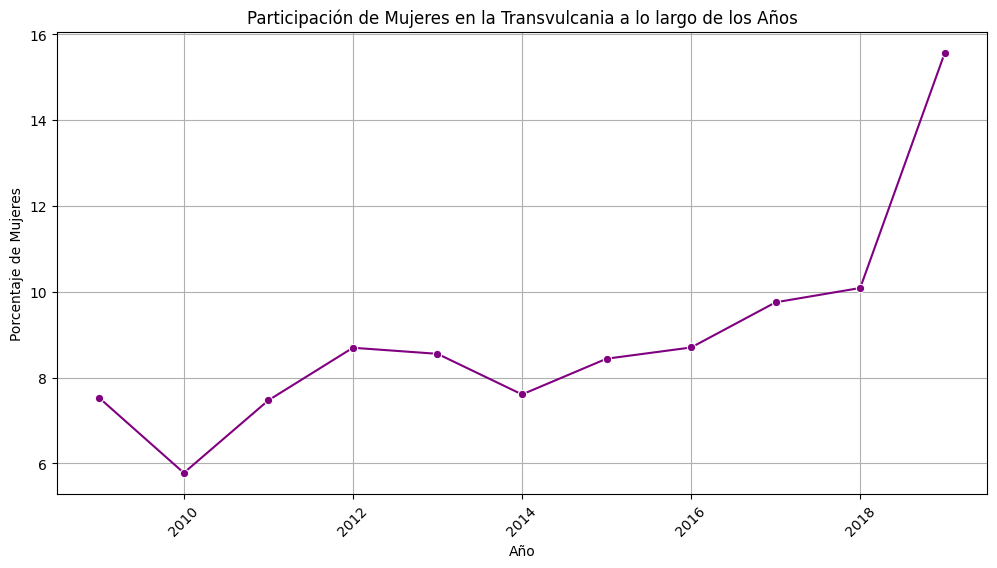

In [ ]:
gender_counts_per_year = df_transvulcania.groupby(['year', 'gender']).size().unstack(fill_value=0)

gender_counts_per_year['female_percentage'] = (gender_counts_per_year['F'] / (gender_counts_per_year['M'] + gender_counts_per_year['F'])) * 100

plt.figure(figsize=(12, 6))
sns.lineplot(x=gender_counts_per_year.index, y=gender_counts_per_year['female_percentage'], marker='o', color='purple')
plt.title('Participación de Mujeres en la Transvulcania a lo largo de los Años')
plt.xlabel('Año')
plt.ylabel('Porcentaje de Mujeres')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#### 4. Análisis de la Velocidad Promedio dividida por género (Violinplot)


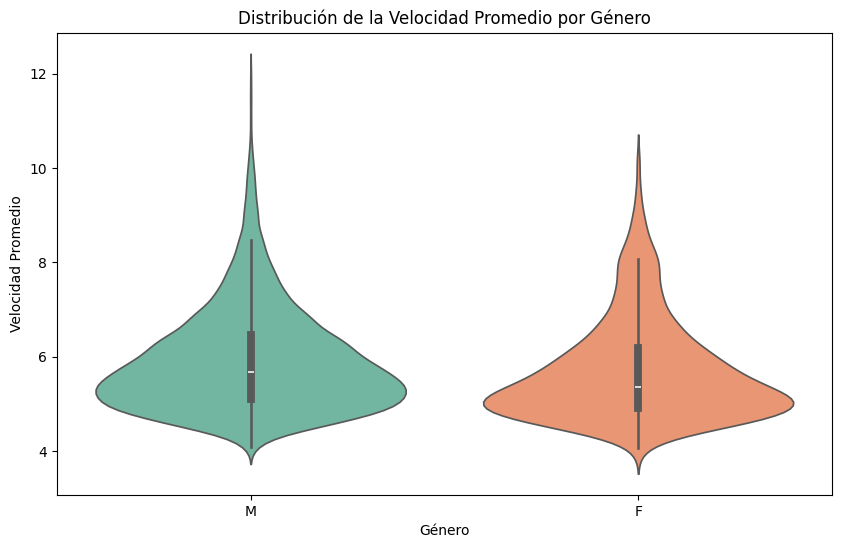

In [32]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='gender', y='avg_speed', data=df_transvulcania, palette='Set2', hue="gender")
plt.title('Distribución de la Velocidad Promedio por Género')
plt.xlabel('Género')
plt.ylabel('Velocidad Promedio')
plt.show()

#### 5. Los 10 países con mayor número de runners

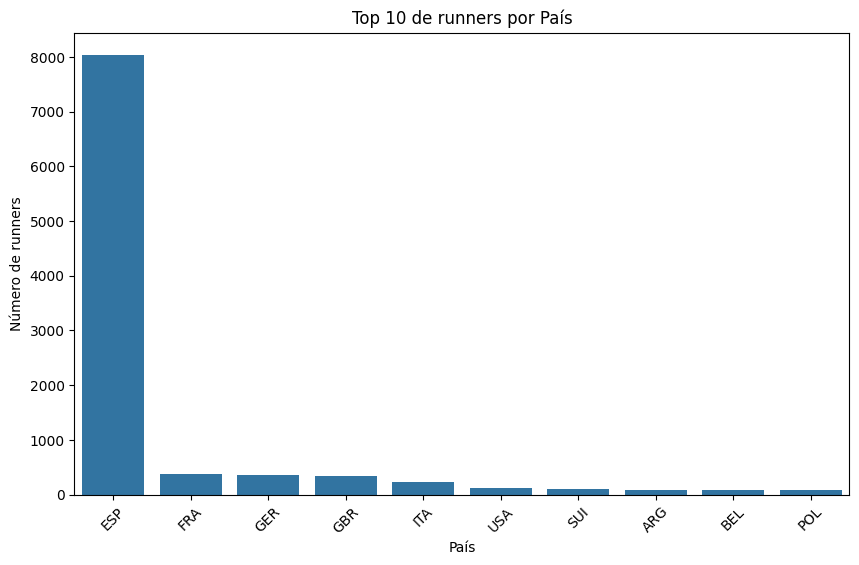

In [ ]:
country_counts = df_transvulcania['country'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=country_counts.index, y=country_counts.values)
plt.title('Top 10 de runners por País')
plt.xlabel('País')
plt.ylabel('Número de runners')
plt.xticks(rotation=45) 
plt.show()

#### 6. Los 10 clubs con mayor número de runners

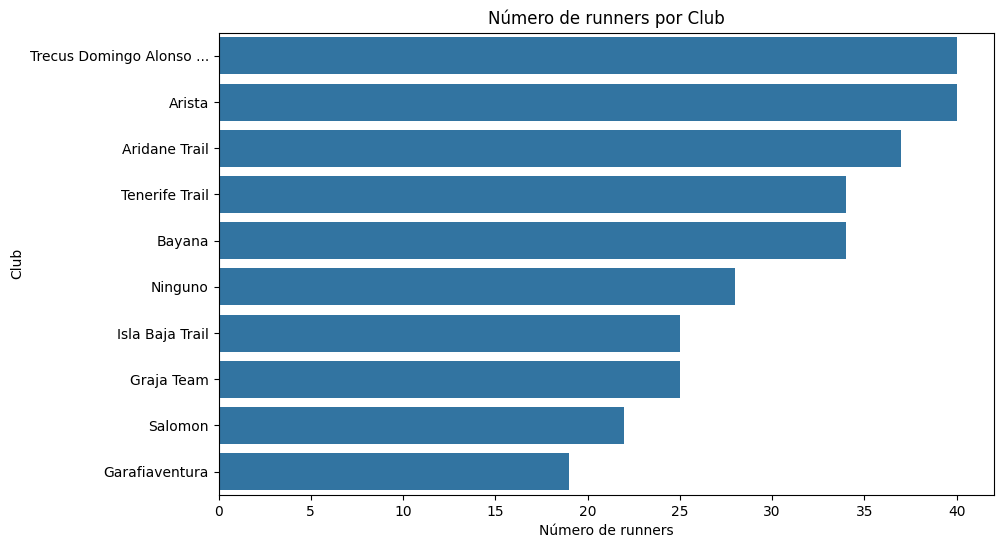

In [42]:
plt.figure(figsize=(10, 6))

df_filtered = df_transvulcania[df_transvulcania['club'] != "Unaffiliated"]

sns.countplot(data=df_filtered, y='club', order=df_filtered['club'].value_counts().head(10).index)

plt.title("Número de runners por Club")
plt.ylabel("Club")
plt.xlabel("Número de runners")
plt.show()


#### 7. Relación entre velocidad media y edad

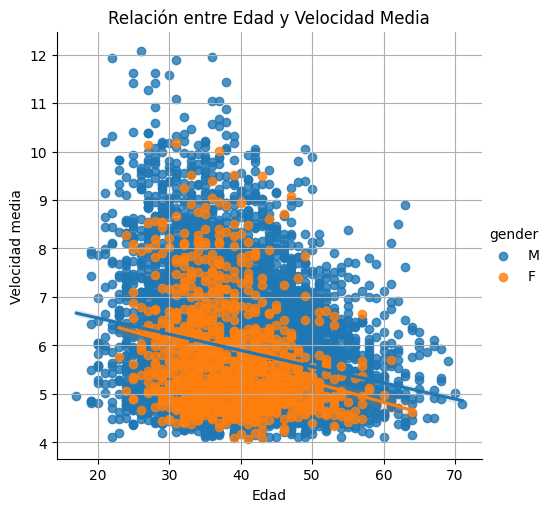

In [35]:
sns.lmplot(data=df_transvulcania, x='age', y='avg_speed', hue='gender')
plt.title('Relación entre Edad y Velocidad Media')
plt.xlabel('Edad')
plt.ylabel('Velocidad media')
plt.grid(True)
plt.show()


#### 8. Matriz de correlación para variables numéricas

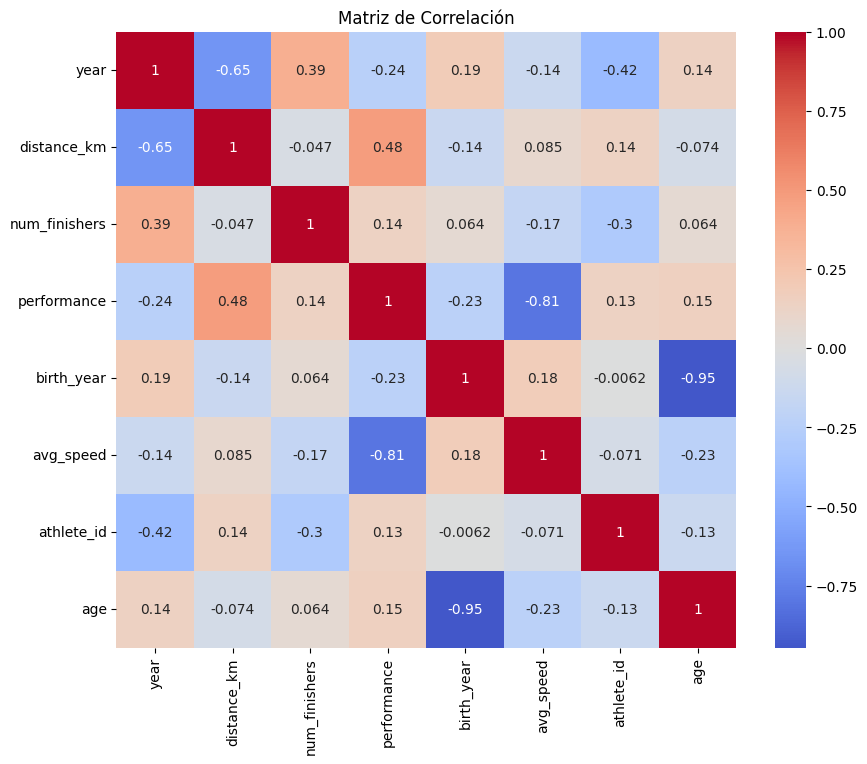

In [36]:
num_cols = df_transvulcania.select_dtypes(include=['number']).columns

corr_matrix = df_transvulcania[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()